## Multi-method/group/trait latent change score models

### 1. Introduction
So far we have seen some very important features of SEM and advantages over other methods to investigate change. However, this is only the tip of the iceberg and SEM offers plenty of capabilities to address more research questions. In order to keep this tutorial short we do not cover all of these capabilities in detail but we illustrate some of them with a short example: 

Imagine that, in addition to the conclusions reached with the previous models, you want to determine: 

- The deviation from change in empathy measured by self reports when empathy is measured by teacher reports. 

- Group differences in this deviation and in the previous questions. In particular, you want to assess differences between the **control** and the **long intervention** groups.

In the past we have included a "dummy-coded" group variable to assess group differences. In dummy regression we can solely assess group differences in mean change and baseline (time-point 1 empathy in our case). However, if we apply a **multiple group model** that simultaneously fits the two group-specific covariance matrices, we can additionally investigate whether the magnitude of **individual differences in change** differs across the two groups. Furthermore, we can investigate measurement invariance not only over time, but also between groups. In summary, a multi-group model allows us to compare the intervention vs. control group with respect to any model parameter estimated that we might wish to compare.  

In [2]:
#######################################################
## Specify R environment for rpy2
#import os
#os.environ['R_HOME'] = r'C:/Program Files/R/R-4.4.3'  # Replace with your R path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
import contextlib
# Ipython extension for plotting
%load_ext rpy2.ipython
########################################################

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

c:\Users\danie\.conda\envs\psy112ER\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


### 2. Data Exploration

`bull_data` is a modified version or our original data frame containing information from the control and long-intervention groups only. The variable "group" indicates group membership. Please feel free to use the code chunks to explore the data frames and gain a good overview.

In [3]:
# Read the CSV file using a relative path
fairplayer = pd.read_csv("../LSCM_and_GCM/Datasets/fairplayer.csv")

# bull_data
# Filter the fairplayer DataFrame and create bull_data
bull_data = pd.concat([
    fairplayer[(fairplayer['IGL'] == 0) & (fairplayer['IGS'] == 0)],
    fairplayer[fairplayer['IGL'] == 1]
]).drop(columns=['IGS']).rename(columns={'IGL': 'group'})

# Display the first few rows of the dataframe
print(bull_data.head())

    ratee  group  sEM01at1  sEM02at1  sEM03at1  tEM01at1  tEM02at1  tEM03at1  \
94  123.0    0.0       NaN       NaN       NaN       NaN       NaN       NaN   
96  124.0    0.0  4.000000  4.000000       4.5  3.000000  3.666667       3.5   
97  125.0    0.0  4.333333  4.666667       3.5  3.666667  3.666667       4.0   
98  126.0    0.0  4.000000  4.000000       3.5  2.333333  3.333333       2.5   
99  127.0    0.0  4.000000       NaN       5.0  3.666667  4.000000       4.0   

    sEM01at2  sEM02at2  ...  sRA03at2  tRA01at2  tRA02at2  tRA03at2  sRA01at3  \
94       NaN       NaN  ...       NaN       NaN       NaN       NaN       1.0   
96  4.000000  4.333333  ...       1.0       1.0       1.5       1.0       1.0   
97  4.333333  4.333333  ...       2.0       1.0       1.0       1.0       3.5   
98  3.666667  3.666667  ...       1.0       2.0       1.5       1.0       3.0   
99  4.333333  4.666667  ...       1.0       1.0       1.0       1.0       1.0   

    sRA02at3  sRA03at3  tRA01at3

### 3. Model Specification

Try to make sense of the *lavaan* syntax shown below in relation to the image. What is each *lavaan* command defining? 

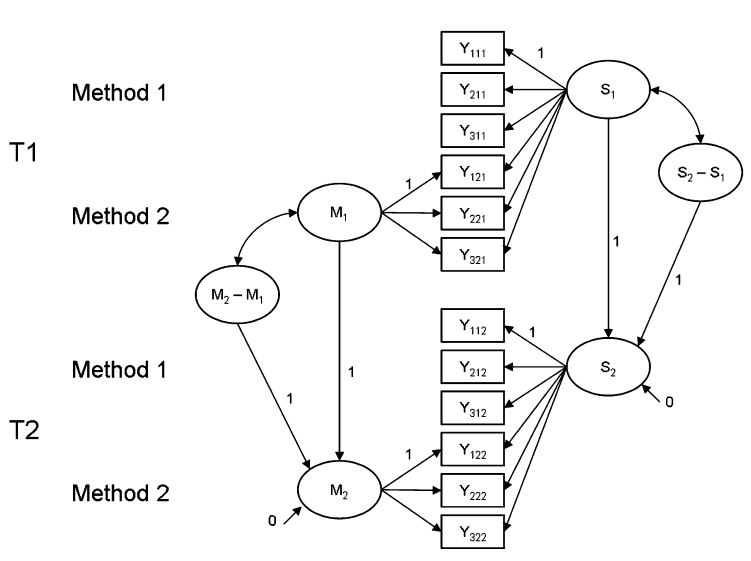

In [4]:
display(Image(filename="../LSCM_and_GCM/Datasets/Fig.1.jpg"))

In [ ]:
# Activate pandas2ri for automatic conversion
pandas2ri.activate()

# Import the lavaan package in R
ro.r('library(lavaan)')

# Import semPlot for plotting SEM paths
ro.r('library(semPlot)')

# Load the dataset into R
ro.globalenv['bull_data'] = pandas2ri.py2rpy(bull_data)

# Define the SEM model
ro.r('''
MGMMlcspm <- '
# =================================   Change score 1: Self-report method factor


# Defining a latent variable representing empathy at time 1, measured as self- and teacher-report
emp1 =~ sEM01at1 + sEM02at1 + sEM03at1 +
tEM01at1 + tEM02at1 + tEM03at1

# Defining a latent variable representing empathy at time 2, measured as self- and teacher-report
emp2 =~ sEM01at2 + sEM02at2 + sEM03at2 + 
tEM01at2 + tEM02at2 + tEM03at2 

# Fixing change score loading to 1
change =~ 1*emp2

# Fixing baseline empathy loadidng to 1
emp2 ~ 1*emp1

# Fixing post-treatment score residual variance to 0
emp2 ~~ 0 * emp2  

# Fixing the intercept of one indicator per timepoint to 0.
sEM01at2 ~ 0*1
sEM01at1 ~ 0*1


# Freely estimate change score variable and baseline means. Per default lavaan would fix them to 0
change ~ 1 
emp1 ~ 1

# Include covariance between change score variable and baseline
change ~~ emp1


# =================================   Change score 2: Teacher-report method factor

# Note that these factors are defined by only their respective indicators teacher-reports:

# Defining a latent variable representing teacher-report as compared with the reference method at time 1
Tea1 =~ tEM01at1 + tEM02at1 + tEM03at1 

# Defining a latent variable representing teacher-report as compared with the reference method at time 2
Tea2 =~ tEM01at2 + tEM02at2 + tEM03at2 


# Fixing change score loading to 1
tch =~ 1*Tea2

# Fixing baseline loading to 1
Tea2 ~ 1*Tea1

# Fixing post-treatment score residual variance to 0
Tea2 ~~ 0 * Tea2  

# Fixing pre- and post-scores intercepts to 0, identify the mean structure
tEM01at1 ~ 0*1
tEM01at2 ~ 0*1

# Freely estimate method change score variable mean, but not Tea1, since deviation is centered around 0
tch ~ 1 

# Include covariance between phantom change variable and baseline
tch ~~ Tea1

# ========================================= Additional specifications
# The method factors (Tea1 and Tea2) are NOT correlated with other latent factors in the model. Likewise, the covariance between the 2 change latent factors is assumed to be 0.

# Fixing method factors means to 0
Tea1 ~ 0*1
Tea2 ~ 0*1

# Fixing covariances to 0, teacher-report independent of the true empathy and the change
Tea1 ~~ 0* emp1
Tea1 ~~ 0* change
change ~~ 0* tch
emp1 ~~ 0*tch

# ======================================= Indicator specific factors

sEM02at1 ~~ sEM02at2
sEM03at1 ~~ sEM03at2

tEM02at1 ~~ tEM02at2
tEM03at1 ~~ tEM03at2

'  
''')


### 4. Fitting the Model

In a multigroup case, the grouping variable is called when fitting the model with `sem()`. By doing so, all parameters are estimated as group-specific and so is the provided output. In other words, simultaneous group modeling provides group-specific parameter estimates across the complete parameter space.
 

In [6]:
# Fit the SEM model
ro.r('fit7=sem(MGMMlcspm, data=bull_data, meanstructure=TRUE, group = "group")')

# Display the summary of the SEM model
summary = ro.r('summary(fit7, fit.measures=TRUE, standardized=TRUE)')
print(summary)

lavaan 0.6-19 ended normally after 180 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        94

  Number of observations per group:               Used       Total
    0                                               36          45
    1                                               43          45

Model Test User Model:
                                                      
  Test statistic                               122.752
  Degrees of freedom                                86
  P-value (Chi-square)                           0.006
  Test statistic for each group:
    0                                           54.874
    1                                           67.877

Model Test Baseline Model:

  Test statistic                               825.192
  Degrees of freedom                               132
  P-value                                        0.000



### 5. Interpretation of the Multi-Group Multi-Method LCSM

**Model Fit:**
The fit of this model to the data is **poor to mediocre**. The **Chi-Square test** is significant (χ²(86) = 122.752, p = 0.006), and while the **CFI (0.947)** and **TLI (0.919)** are borderline acceptable, the **RMSEA (0.104)** and **SRMR (0.125)** are high and indicate a poor fit. Because the model as a whole does not represent the data well, the specific parameter estimates below should be interpreted with **caution**.

---

#### Group 0 (Control Group) Interpretation

* **Mean Change in Empathy:** The average change in true empathy (`change`) for the control group was **0.223**. This result is borderline significant (p = 0.051), providing only weak evidence for a small increase in empathy over time.
* **Mean Change in Teacher Bias:** The average change in the teacher-specific method factor (`tch`) was **1.274**, which was not statistically significant (p = 0.166).
* **Individual Differences (Variances):** There were significant individual differences in all latent factors:
    * Initial empathy (`emp1` variance = 0.309, p = 0.005)
    * Empathy change (`change` variance = 0.124, p = 0.047)
    * Initial teacher bias (`Tea1` variance = 0.543, p < 0.001)
    * Teacher bias change (`tch` variance = 0.168, p = 0.004)
* **Coupling of Trait and Change:** The covariance between the initial empathy level and its change was **-0.072**, which was not significant (p = 0.320).

---

#### Group 1 (Intervention Group) Interpretation

* **Mean Change in Empathy:** For the intervention group, the average change in true empathy (`change`) was **0.072**. This was **not statistically significant** (p = 0.430).
* **Mean Change in Teacher Bias:** The average change in the teacher-specific method factor (`tch`) was **0.329** and also not significant (p = 0.686).
* **Individual Differences (Variances):** This group also showed significant individual differences in all latent factors:
    * Initial empathy (`emp1` variance = 0.350, p < 0.001)
    * Empathy change (`change` variance = 0.083, p = 0.042)
    * Initial teacher bias (`Tea1` variance = 0.585, p < 0.001)
    * Teacher bias change (`tch` variance = 0.339, p = 0.002)
* **Coupling of Trait and Change:** The covariance between the initial empathy level and its change was **-0.020** and not significant (p = 0.736).

---

#### Overall Conclusion

This model was designed to answer two main questions: 1) Did the intervention group show a greater change in empathy than the control group? and 2) Did the way teacher ratings deviate from self-reports change over time for either group?

1.  **Intervention Effect:** Based on the model's results, **we find no evidence that the intervention was effective**. The average change in true empathy (`change`) in the intervention group was not significantly different from zero (Estimate = 0.072, p = 0.430) and was smaller than the borderline-significant change in the control group (Estimate = 0.223, p = 0.051).

2.  **Deviation in Change (Method Effect):** Regarding the deviation of teacher reports, the model assessed the change in the teacher-specific method factor (`tch`). The results showed that the average change in this method factor was **not statistically significant** for either the **control group (Estimate = 1.274, p = 0.166)** or the **intervention group (Estimate = 0.329, p = 0.686)**. This suggests that the way teachers' ratings systematically deviate from the students' self-reports remained stable over time for both groups.

**Final Caveat:** It is critical to restate that these conclusions are highly tentative. The **poor overall model fit** (with high RMSEA and SRMR values) suggests that the model itself may be misspecified and not a valid representation of the data. Therefore, any conclusions about the intervention or method effects are questionable until a better-fitting model can be established.